In [1]:
# Importing modules
import pandas as pd
from tqdm.notebook import tqdm, trange
import time
import geopandas as gpd
import requests
import matplotlib.pyplot as plt 
import io
import os
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# A dataframe containing all the zip codes within the United States
# Taking the centroid of the zip code areas
zips = gpd.read_file(r"..\..\PQHS_427_Proj_Data\US Zip Codes\tl_2020_us_zcta520.shp")
zips = zips.to_crs('EPSG:26917')
zipCentroids = zips.centroid
# Reading in the shapefile countaining State boundaries for the United States 
states = gpd.read_file(r"..\..\PQHS_427_Proj_Data\US State Boundaries\cb_2018_us_state_500k.shp")
states = states.to_crs('EPSG:26917')
# Selecting the states of OH, PA and WV
oh_state = states[states['STATEFP'] == '39']
pa_state = states[states['STATEFP'] == '42']
wv_state = states[states['STATEFP'] == '54']
# Obtaining the zip codes within each state
oh_zips = zips[zipCentroids.within(oh_state.geometry.values[0])]
pa_zips = zips[zipCentroids.within(pa_state.geometry.values[0])]
wv_zips = zips[zipCentroids.within(wv_state.geometry.values[0])]

In [3]:
# Geocoding the East Palestine train derailment
crash_site_lat = []
crash_site_long = []
crash_site_name = []
crash_site_name.append("east_palestine")
crash_site_lat.append(40.836)
crash_site_long.append(-80.5227)
crash_df = pd.DataFrame(crash_site_name, columns=['site_name'])
crash_df['latitude'] = crash_site_lat
crash_df['longitude'] = crash_site_long
crash_df.longitude = crash_df['longitude'].astype(float)
crash_df.latitude = crash_df['latitude'].astype(float)
# Creating a geometry column using longitude and latitude data
geometry = gpd.points_from_xy(crash_df.longitude, crash_df.latitude)
# Creating a GeoDataFrame with the site data and the geometry column. CRS is set to EPSG:4269
crash_gdf = gpd.GeoDataFrame(crash_df, geometry=geometry, crs="EPSG:4269")

In [4]:
# Reprojecting all the sites under study
crash_gdf = crash_gdf.to_crs('EPSG:26917')
zips = zips.to_crs('EPSG:26917')
zipCentroids = zipCentroids.to_crs('EPSG:26917')
oh_state = oh_state.to_crs('EPSG:26917')
pa_state = pa_state.to_crs('EPSG:26917')
wv_state = wv_state.to_crs('EPSG:26917')

In [5]:
crash_gdf.crs

<Derived Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 84°W and 78°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Florida; Georgia; Kentucky; Maryland; Michigan; New York; North Carolina; Ohio; Pennsylvania; South Carolina; Tennessee; Virginia; West Virginia.
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# Creating a buffer zone of 30 miles around the crash site
crashBuffer = crash_gdf.buffer(30*1609.34)
# Finding the zip codes within the crash site buffer zone
crash_zips = zips[zipCentroids.within(crashBuffer.geometry.values[0])]

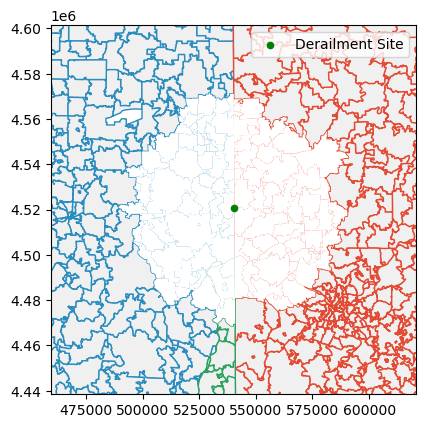

In [11]:
#Plotting the data
f, ax = plt.subplots()
# Get the bounding box of the polygons
bounds = crash_zips.bounds
xmin, ymin = bounds.minx.min(), bounds.miny.min()
xmax, ymax = bounds.maxx.max(), bounds.maxy.max()
# Set the x and y limits to center the view on the polygons
padding = 30000
ax.set_xlim(xmin - padding, xmax + padding)
ax.set_ylim(ymin - padding, ymax + padding)
# Setting the x and y limits to center the view on the polygons
oh_zips.plot(ax = ax, edgecolor = '#2b8cbe', label='Ohio',facecolor = "#f0f0f0")
pa_zips.plot(ax = ax, edgecolor = '#e34a33', label = 'Pennsylvania',facecolor = "#f0f0f0")
wv_zips.plot(ax = ax, edgecolor = '#2ca25f', label = 'West Virginia',facecolor = "#f0f0f0")
crash_zips.plot(ax=ax, edgecolor='none', facecolor = "white");
crash_gdf.plot(ax=ax, color ='green', markersize = 20, label ='Derailment Site')
ax.legend()


In [19]:
f.savefig('zips.png', dpi = 300, bbox_inches='tight')

In [21]:
# Getting a list of the zip codes within the buffer zone
zipcodes = []
for i in crash_zips['ZCTA5CE20']:
    zipcodes.append(i)
len(zipcodes)

130

In [ ]:
zipcodes

# EPA API requests


In [ ]:
# Define API parameters
api_keys = ["xxx"] # Insert your key(s) here
api_key_counts = {key: 0 for key in api_keys}
base_url = 'https://www.airnowapi.org/aq/observation/zipCode/historical/'
params = {
    'format': 'text/csv',
    'distance': '25',
    'API_KEY': '',
    'parameterName': ''
}

date_range = pd.date_range(start='2023-01-01', end='2023-02-28', freq='D')

# Define error handling and rate limiting functions
def handle_request_error(url, retry_count=5, delay=10):
    for i in range(retry_count):
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                return pd.read_csv(io.StringIO(response.text))
            else:
                print(f'Error: Could not get data from {url} - HTTP status code {response.status_code}')
                time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f'Error: {e}')
            time.sleep(delay)
    return None

def check_api_key_rate_limit(api_key, max_requests_per_hour=500):
    if api_key_counts[api_key] >= max_requests_per_hour:
        reset_time = (60 - time.localtime().tm_min) * 60 - time.localtime().tm_sec
        print(f'API key {api_key} has reached the maximum requests per hour. Waiting {reset_time}s before resuming requests.')
        time.sleep(reset_time)
        api_key_counts[api_key] = 0
    api_key_counts[api_key] += 1

# Loop over zip codes and date range
dfs = []
api_key_index = 0
for zip_code in tqdm(zipcodes, desc='Zip Codes'):
    for date in date_range:
        date_str = date.strftime('%Y-%m-%dT00-0000')
        api_key = api_keys[api_key_index]
        url = f'{base_url}?zipCode={zip_code}&date={date_str}&API_KEY={api_key}'
        check_api_key_rate_limit(api_key)
        df = handle_request_error(url)
        if df is not None:
            df['zip_code'] = zip_code
            dfs.append(df)
        else:
            print(f'Error: Could not get data for zip code {zip_code} and date {date_str}')
        time.sleep(2.4)
        api_key_index = (api_key_index + 1) % len(api_keys)
        if api_key_index == 0:
            final_df = pd.concat(dfs, ignore_index=True)
            final_df.to_csv(r"..\..\PQHS_427_Proj_Data\02_air_dat.csv", index=False, mode='a', header=False)
            dfs.clear()

# Save any remaining data
if dfs:
    final_df = pd.concat(dfs, ignore_index=True)
    final_df.to_csv(r"..\..\PQHS_427_Proj_Data\02_air_dat.csv", index=False, mode='a', header=False)
